In [1]:
%matplotlib inline

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/dan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dan/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
data = pd.read_json("train.json")[["request_text","requester_received_pizza"]]
print data.shape
train_data = data[:3500]["request_text"]
train_labels = data[:3500]["requester_received_pizza"]
dev_data = data[3501:]["request_text"]
dev_labels = data[3501:]["requester_received_pizza"]

(4040, 2)


In [4]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def better_preprocessor(s):
    message = s.lower()
    message = re.sub(r"[^a-z]", " ", message)
    message = re.sub(r"[-]*", "", message)
    return message

def stemming_tokenizer(str_input):
    words = re.sub(r"[^a-z]", " ", str_input).split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [5]:
cv = TfidfVectorizer(stop_words='english',preprocessor=better_preprocessor,tokenizer=stemming_tokenizer)
transformer = cv.fit_transform(train_data)
classifier = KNeighborsClassifier(n_neighbors=11)
classifier.fit(transformer,train_labels)
dev_data_trans = cv.transform(dev_data)
y_pred = classifier.predict(dev_data_trans)
print "Default F1-score (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)

Default F1-score (on dev set): 0.7570


In [6]:
cv = CountVectorizer(stop_words='english',preprocessor=better_preprocessor,tokenizer=stemming_tokenizer)
transformer = cv.fit_transform(train_data)
classifier = LogisticRegression(C=0.001)
classifier.fit(transformer,train_labels)
dev_data_trans = cv.transform(dev_data)
y_pred = classifier.predict(dev_data_trans)
print "Default F1-score (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)

Default F1-score (on dev set): 0.7570


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, so

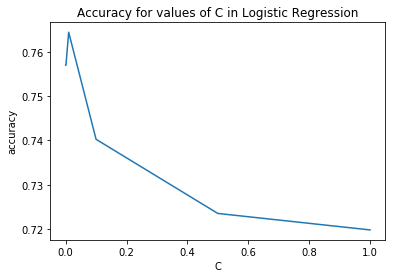

optimal C =  0.01
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
    accuracy  =  0.764378478664193



In [7]:
def find_optimal_C():
    vectorizer = CountVectorizer(stop_words='english',preprocessor=better_preprocessor,tokenizer=stemming_tokenizer)
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    # Fit for logistic regression
    C_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]
    accuracies = []
    for C in C_list:
        lr = LogisticRegression(C=C).fit(X_train,train_labels)
        accuracies.append(lr.score(X_dev,dev_labels))
        print lr
        print
       
    plt.plot(C_list,accuracies)
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.title('Accuracy for values of C in Logistic Regression')
    #plt.ylim(.64,.72)
    plt.show()
   
    optimal_C = C_list[accuracies.index(max(accuracies))]
    print "optimal C = ",optimal_C
    lr = LogisticRegression(C=optimal_C).fit(X_train,train_labels)
    print lr
    print "    accuracy  = ",max(accuracies)
    print
 
find_optimal_C()

In [78]:
cv = TfidfVectorizer(stop_words='english',preprocessor=better_preprocessor,tokenizer=stemming_tokenizer)
transformer = cv.fit_transform(train_data)
classifier = LogisticRegression(C=0.001)
classifier.fit(transformer,train_labels)
dev_data_trans = cv.transform(dev_data)
y_pred = classifier.predict(dev_data_trans)
print "Default F1-score (on dev set): %.4f" % metrics.accuracy_score(y_true=dev_labels, y_pred=y_pred)

Default F1-score (on dev set): 0.7570


In [90]:
print metrics.classification_report(y_true=dev_labels, y_pred=y_pred)

             precision    recall  f1-score   support

      False       0.76      1.00      0.86       408
       True       0.00      0.00      0.00       131

avg / total       0.57      0.76      0.65       539

